Imaging Through Turbulence
==============


This notebook shows examples of using `aotools` to do the following:
- Create a PSF from an aperture function
- Measure the structure of PSFs
- Create aberrated PSFs including turbulence
- Apply PSFs to extended images


In [1]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
%matplotlib inline
import aotools
from aotools.turbulence import infinitephasescreen
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as colors
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov

import scipy.signal
j = 0+1j

Like before we need to set the parameters for the scale of our simulation and the strength of atmospheric turbulence we want to simulate.

In [2]:
# Set up parameters for creating phase screens
nx_size = 64
D = 1.
pxl_scale = D/nx_size
r0 = 0.32
L0 = 100
wind_speed = 10 #m/s - just arbitrarily set
stencil_length_factor = 32
wavelength = 500e-9

Before looking at aberrated PSFs first we will show the process of creating a simple PSF for a flat incident wavefront. To do this we impose a circular aperture on the phase screen in order to create a more realistic optical system. This can be done by multiplying the screen by the circular function `aotools.circle`.

In [3]:
pupil = aotools.circle(nx_size/2, nx_size)

This simply creates a mask which we can use to create more realistic simulations of optical systems.

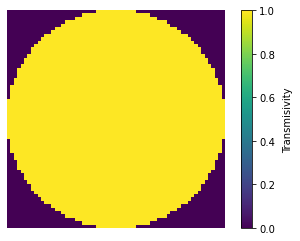

In [4]:
plt.figure()
plt.imshow(pupil)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Transmisivity', labelpad=8)

The most simplistic way of simulating an imaging optical system is to use Fourier Transforms in order to calculate the PSF of the aperture.

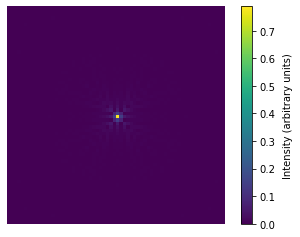

In [5]:
psf = aotools.ft2(pupil, delta=D/nx_size)

plt.figure()
plt.imshow(numpy.abs(psf))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

Note that this PSF does not look particularly well sampled, although the spatial scales are included based on the input parameters. We should properly sample the PSF similar to Nyquist sampling. This will create a "smoother" image and ensure we have a properly sampled PSF.

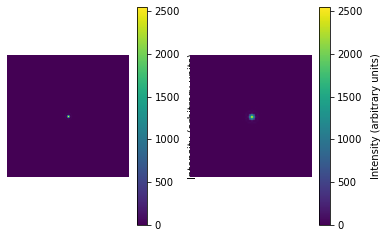

In [6]:
# Create padding to get an oversampled psf at the end to make it look nice
padded_pupil = numpy.zeros((nx_size*2, nx_size*2))
y, x = padded_pupil.shape
padded_pupil[:nx_size, :nx_size] = pupil

# Use AOtools to transform from the pupil to the focal plane
psf = aotools.ft2(padded_pupil, delta=D*8/nx_size,)**2.

# Cut out the centre of the psf array for prettier plotting
psf_cut = psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(numpy.abs(psf))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)
plt.subplot(1, 2, 2)
plt.imshow(numpy.abs(psf_cut))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

The PSF produced is circularly symmetric, so we can use the `aotools.azimuthal_average` function in order to show the PSF more clearly.

Text(0, 0.5, 'relative intensity')

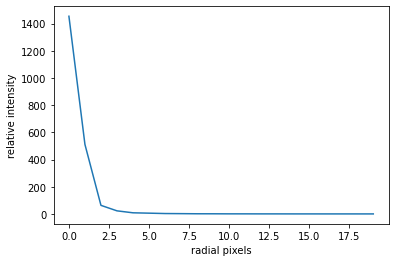

In [7]:
azi_avg = aotools.azimuthal_average(numpy.abs(psf))
plt.figure()
plt.plot(azi_avg[:20])
plt.xlabel("radial pixels")
plt.ylabel("relative intensity")

Usually we want some physical unit which is useful to us, not simply "pixels". The spatial scale of the image plane after a Fourier Transform is given by $\frac{\lambda}{2D}$. This includes the oversampling in the Fourier transform (the factor of 2 on the denomenator).

Adding Turbulence
-----------------
Now we have these tools we can look at how turbulence affects these PSFs. First we need to create a phase screen object to interact with.

In [8]:
# Create the phase screen object using aotools
phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)

Now we impose a circular aperture on the phase screen in order to create a more realistic optical system. This can be done by multiplying the screen by the circular function `aotools.circle`.

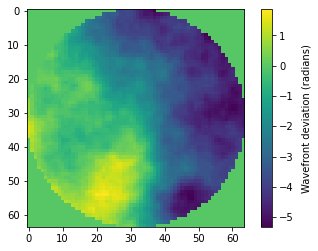

In [9]:
wavefront = phase_screen.scrn
wavefront *= aotools.circle(nx_size/2, nx_size)

plt.figure()
plt.imshow(wavefront)
cbar = plt.colorbar()
cbar.set_label('Wavefront deviation (radians)', labelpad=8)

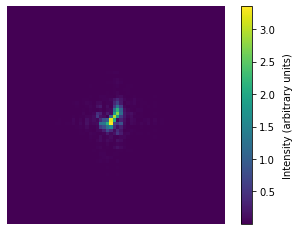

In [19]:
complex_phase = numpy.exp(j*wavefront)

# Create padding to get an oversampled psf at the end to make it look nice
padded_pupil = numpy.zeros((nx_size*2, nx_size*2), dtype=numpy.complex64)
padded_pupil[:nx_size, :nx_size] = complex_phase

# Use AOtools to transform from the pupil to the focal plane
psf = numpy.abs(aotools.ft2(padded_pupil, delta=D*2/nx_size,))**2

# Cut out the centre of the psf array for prettier plotting
psf_cut = psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.imshow(numpy.abs(psf_cut))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

This is an instantanious snapshot of the turbulence, so generates and instantanious PSF. This is not the averaged PSF which a traditional "slow" camera would see. In order to generate this from simulation we would need to average many instances of turbulence.

In [21]:
n_scrns = 100
padded_pupil = numpy.zeros((nx_size*2, nx_size*2), dtype=numpy.complex64)
psfs = numpy.zeros((n_scrns, nx_size*2, nx_size*2))

for n in tqdm(range(n_scrns)):
    phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)
    wavefront = numpy.copy(phase_screen.scrn)
    padded_pupil[:nx_size, :nx_size] = numpy.exp(j*wavefront*aotools.circle(nx_size/2, nx_size))
    psf = numpy.abs(aotools.ft2(padded_pupil, delta=D*2/nx_size,))**2.
    psfs[n] = numpy.copy(psf)

average_psf = psfs.mean(0)

100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


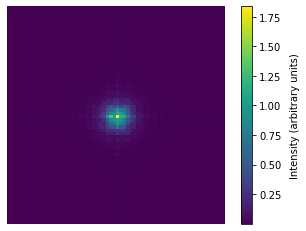

In [22]:
# Cut out the centre of the psf array for prettier plotting
psf_cut = average_psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]

# Plot the PSF
plt.figure()
plt.imshow(numpy.abs(psf_cut))
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

We can also see how a PSF evolves as a phase screen evolves, similarly to how we saw the phase screen evolve previously.

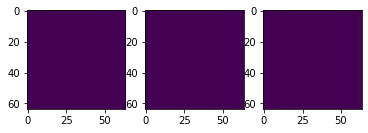

In [25]:
r0=0.32
frames=1000
nx_size=64

phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)
padded_pupil = numpy.zeros((nx_size*2, nx_size*2), dtype=numpy.complex64)
psfs = numpy.zeros((frames, nx_size*2, nx_size*2))

# Video of moving a phase screen and PSF
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3)
screen_image = ax1.imshow(numpy.zeros((nx_size, nx_size)))
psf_image = ax2.imshow(numpy.zeros((nx_size, nx_size)))
average_image = ax3.imshow(numpy.zeros((nx_size, nx_size)))

def init():
    screen_image.set_data(numpy.zeros((nx_size, nx_size)))
    psf_image.set_data(numpy.zeros((nx_size, nx_size)))
    average_image.set_data(numpy.zeros((nx_size, nx_size)))
    return (screen_image, psf_image, average_image,)

def animate(i):  
    phase_screen.add_row()
    wavefront = numpy.copy(phase_screen.scrn)
    screen_image.set_data(wavefront*aotools.circle(nx_size/2, nx_size))
    screen_image.autoscale()
    
    padded_pupil[:nx_size, :nx_size] = numpy.exp(j*wavefront*aotools.circle(nx_size/2, nx_size))
    
    # Use AOtools to transform from the pupil to the focal plane
    psf = numpy.abs(aotools.ft2(padded_pupil, delta=D*2/nx_size,))**2.
    
    psf_cut = psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]
    
    psf_image.set_data(psf_cut)
    psf_image.autoscale()
    
    psfs[i] = numpy.copy(psf)
    average_psf = psfs[:i+1].mean(0)
    average_psf_cut = average_psf[int(y/2-nx_size/2):int(y/2+nx_size/2), int(y/2-nx_size/2):int(y/2+nx_size/2)]
    
    average_image.set_data(average_psf_cut)
    average_image.autoscale()
    
    return (screen_image, psf_image, average_image)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=100, 
                               blit=True)

In [26]:
HTML(anim.to_html5_video())

Extended Sources
================

We can apply PSFs we have generated here to extended sources using convolutions. First lets load an image of some solar granulation.

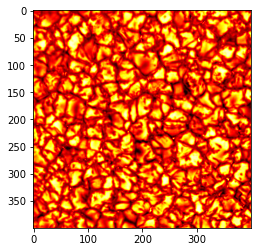

In [47]:
image = fits.getdata("sun_small.fits")[:400, :400]
average_psf = psfs.mean(0)

plt.figure()
plt.imshow(image, cmap='hot')

We can "apply" turbulence to images by convovling them with a PSF. Equally we can apply the diffraction from an aperture, or the effects from telescopes such as the secondary obscuration and spiders.

If applying a PSF to an extended image it is important to make sure the spatial scales of the PSF and the image match.

In [48]:
aberrated_image = scipy.signal.convolve2d(image, average_psf.mean(0), mode='same')

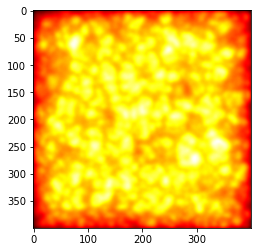

In [49]:
plt.figure()
plt.imshow(aberrated_image, cmap='hot')

There are a few things to note here. Firstly, applying the aberrated PSF has clearly reduced the "resolution" of the image. Secondly, this has led to a reduction in teh contrast. Finally, using this simple method to apply a PSF means that the edges have artifacts.